# BASELINE

In [616]:
import torch
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Flatten
from sklearn.preprocessing import LabelEncoder


In [617]:
plt.rc('font', family='AppleGothic')

In [618]:
train = pd.read_csv('/Users/chaewon/Desktop/공모전/DACON_제주/data/train.csv')
trade = pd.read_csv('/Users/chaewon/Desktop/공모전/DACON_제주/data/international_trade.csv')
test = pd.read_csv('/Users/chaewon/Desktop/공모전/DACON_제주/data/test.csv')

In [619]:
train = train.rename(columns={'supply(kg)': 'supply', 'price(원/kg)': 'price'})
train.drop(columns=['ID'], inplace=True) 

In [655]:
train.head()

,timestamp,supply,price,year,month,day,item_BC,item_CB,item_CR,item_RD,item_TG,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S
2,2019-01-03,60601.0,1728.0,2019,1,3,False,False,False,False,True,True,False,False,False,False,False,True,False
3,2019-01-04,25000.0,1408.0,2019,1,4,False,False,False,False,True,True,False,False,False,False,False,True,False
4,2019-01-05,32352.0,1250.0,2019,1,5,False,False,False,False,True,True,False,False,False,False,False,True,False
6,2019-01-07,44995.0,1474.0,2019,1,7,False,False,False,False,True,True,False,False,False,False,False,True,False
7,2019-01-08,26975.0,1326.0,2019,1,8,False,False,False,False,True,True,False,False,False,False,False,True,False


In [621]:
len(train)

59397

In [622]:
train_null = train[(train['supply'] == 0) & (train['price'] == 0)]

In [623]:
len(train_null)

35452

In [624]:
TGnull = train_null[train_null['item'] == 'TG']
TGnull[TGnull['item'] == 'TG']

,timestamp,item,corporation,location,supply,price
0,2019-01-01,TG,A,J,0.0,0.0
1,2019-01-02,TG,A,J,0.0,0.0
5,2019-01-06,TG,A,J,0.0,0.0
12,2019-01-13,TG,A,J,0.0,0.0
19,2019-01-20,TG,A,J,0.0,0.0
...,...,...,...,...,...,...
15196,2023-01-29,TG,E,S,0.0,0.0
15203,2023-02-05,TG,E,S,0.0,0.0
15210,2023-02-12,TG,E,S,0.0,0.0
15217,2023-02-19,TG,E,S,0.0,0.0


In [625]:
TGnull[TGnull['item'] == 'TG']['timestamp'].unique()

array(['2019-01-01', '2019-01-02', '2019-01-06', '2019-01-13',
       '2019-01-20', '2019-01-27', '2019-02-03', '2019-02-05',
       '2019-02-06', '2019-02-07', '2019-02-08', '2019-02-10',
       '2019-02-17', '2019-02-24', '2019-03-03', '2019-03-10',
       '2019-03-17', '2019-03-24', '2019-03-29', '2019-03-31',
       '2019-04-04', '2019-04-05', '2019-04-06', '2019-04-07',
       '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-14',
       '2019-04-15', '2019-04-16', '2019-04-17', '2019-04-18',
       '2019-04-20', '2019-04-21', '2019-04-25', '2019-04-26',
       '2019-04-27', '2019-04-28', '2019-04-29', '2019-04-30',
       '2019-05-02', '2019-05-03', '2019-05-04', '2019-05-05',
       '2019-05-07', '2019-05-08', '2019-05-12', '2019-05-13',
       '2019-05-16', '2019-05-18', '2019-05-19', '2019-05-20',
       '2019-05-21', '2019-05-22', '2019-05-23', '2019-05-24',
       '2019-05-25', '2019-05-26', '2019-05-27', '2019-05-28',
       '2019-05-29', '2019-05-30', '2019-05-31', '2019-

In [626]:
train.isnull().sum()

timestamp      0
item           0
corporation    0
location       0
supply         0
price          0
dtype: int64

In [627]:
train = train[~((train['price'] == 0) & (train['supply'] == 0))] #0인 데이터 일단 drop


In [628]:
train['timestamp'] = pd.to_datetime(train['timestamp'])

In [629]:
train['year'] = pd.to_datetime(train['timestamp']).dt.year
train['month'] = pd.to_datetime(train['timestamp']).dt.month
train['day'] = pd.to_datetime(train['timestamp']).dt.day
df_encoded = pd.get_dummies(train, columns=['item', 'corporation', 'location'])
#df_encoded.drop(columns=['timestamp'], inplace=True)
train= df_encoded
print(train.columns)

Index(['timestamp', 'supply', 'price', 'year', 'month', 'day', 'item_BC',
       'item_CB', 'item_CR', 'item_RD', 'item_TG', 'corporation_A',
       'corporation_B', 'corporation_C', 'corporation_D', 'corporation_E',
       'corporation_F', 'location_J', 'location_S'],
      dtype='object')


In [630]:
trade.head()

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [631]:
trade.isnull().sum()

기간       0
품목명      0
수출 중량    0
수출 금액    0
수입 중량    0
수입 금액    0
무역수지     0
dtype: int64

In [632]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기간      1274 non-null   object
 1   품목명     1274 non-null   object
 2   수출 중량   1274 non-null   int64 
 3   수출 금액   1274 non-null   int64 
 4   수입 중량   1274 non-null   int64 
 5   수입 금액   1274 non-null   int64 
 6   무역수지    1274 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 69.8+ KB


In [633]:
test.head()

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [634]:
test['year'] = pd.to_datetime(test['timestamp']).dt.year
test['month'] = pd.to_datetime(test['timestamp']).dt.month
test['day'] = pd.to_datetime(test['timestamp']).dt.day
#test.drop(columns=['timestamp'], inplace=True)
test.drop(columns=['ID'], inplace=True)
df_encoded2 = pd.get_dummies(test, columns=['item','corporation', 'location'])
test= df_encoded2
print(test.columns)

Index(['timestamp', 'year', 'month', 'day', 'item_BC', 'item_CB', 'item_CR',
       'item_RD', 'item_TG', 'corporation_A', 'corporation_B', 'corporation_C',
       'corporation_D', 'corporation_E', 'corporation_F', 'location_J',
       'location_S'],
      dtype='object')


In [635]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   timestamp      1092 non-null   object
 1   year           1092 non-null   int32 
 2   month          1092 non-null   int32 
 3   day            1092 non-null   int32 
 4   item_BC        1092 non-null   bool  
 5   item_CB        1092 non-null   bool  
 6   item_CR        1092 non-null   bool  
 7   item_RD        1092 non-null   bool  
 8   item_TG        1092 non-null   bool  
 9   corporation_A  1092 non-null   bool  
 10  corporation_B  1092 non-null   bool  
 11  corporation_C  1092 non-null   bool  
 12  corporation_D  1092 non-null   bool  
 13  corporation_E  1092 non-null   bool  
 14  corporation_F  1092 non-null   bool  
 15  location_J     1092 non-null   bool  
 16  location_S     1092 non-null   bool  
dtypes: bool(13), int32(3), object(1)
memory usage: 35.3+ KB


In [636]:
#특산물별 df 생성
TG = train[train['item'] == 'TG']
CR = train[train['item'] == 'CR']
BC = train[train['item'] == 'BC']
CB = train[train['item'] == 'CB']
RD = train[train['item'] == 'RD']

KeyError: 'item'

## 1. 귤!

In [ ]:
TG = TG.sort_values(by='timestamp')

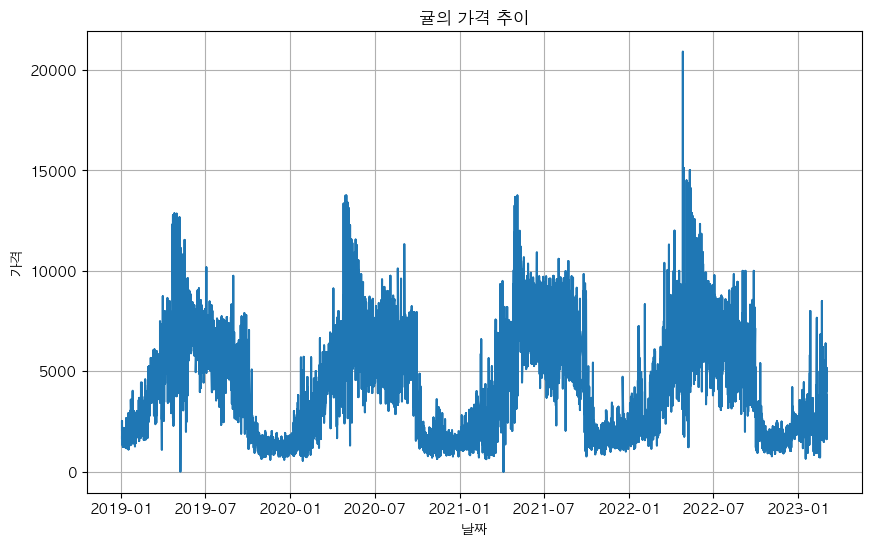

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(TG['timestamp'], TG['price'])
plt.xlabel('날짜')
plt.ylabel('가격')
plt.title('귤의 가격 추이')
plt.grid(True)
plt.show()

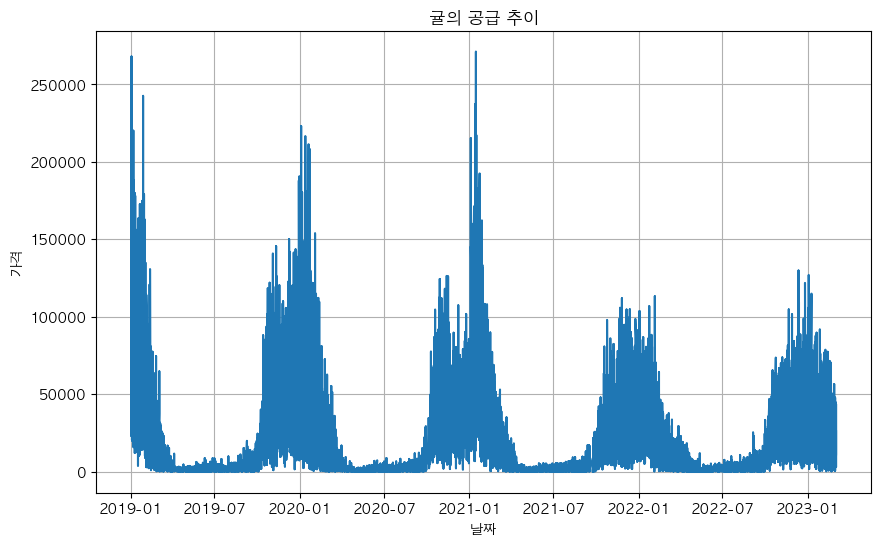

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(TG['timestamp'], TG['supply'])
plt.xlabel('날짜')
plt.ylabel('가격')
plt.title('귤의 공급 추이')
plt.grid(True)
plt.show()

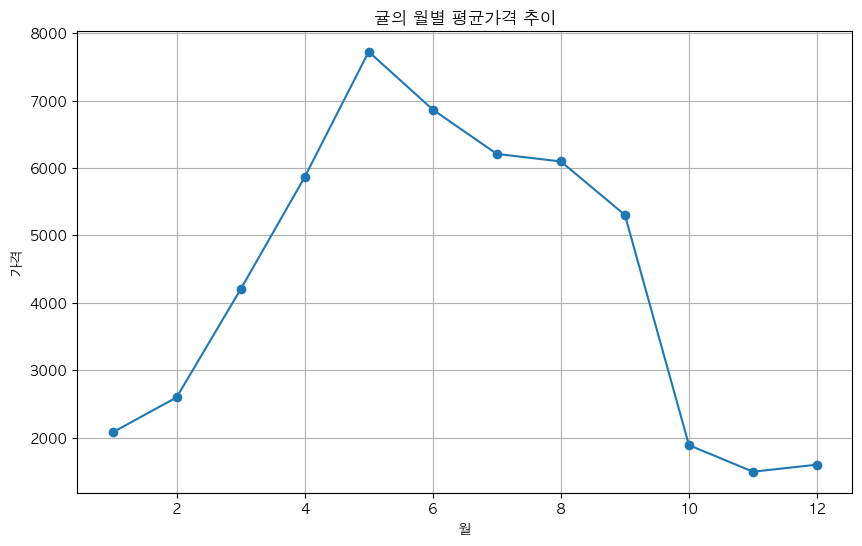

In [ ]:
#월별 가격
monthly_price = TG.groupby('month')['price'].mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_price.index, monthly_price, marker = 'o')
plt.xlabel('월')
plt.ylabel('가격')
plt.title('귤의 월별 평균가격 추이')
plt.grid(True)
plt.show()


In [ ]:
#월별 공급
 = TG.groupby('month')['price'].mean()
plt.figure(figsize=(10, 6))
plt.plot(monthly_price.index, monthly_price, marker = 'o')
plt.xlabel('월')
plt.ylabel('가격')
plt.title('귤의 월별 평균가격 추이')
plt.grid(True)
plt.show()

IndentationError: unexpected indent (2669395895.py, line 2)

## 2. dummy처리

In [652]:
lstmtrain = train.copy()

In [654]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten

# ... (Your previous code)
lstmtrain = lstmtrain.drop(columns=['timestamp'])
test = test.drop(columns=['timestamp'])

lstmtrain['march'] = (lstmtrain['month'] == 3).astype(int)
X_train = lstmtrain.drop(columns=['price', 'supply'], axis=1)
X_train = np.array(X_train, dtype=np.float32)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

y_train = np.array(lstmtrain[['price']], dtype=np.float32)

model = Sequential()
model.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model.fit(X_train, y_train, epochs=50, batch_size=32)


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 16)                1152      
                                                                 
 flatten_26 (Flatten)        (None, 16)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1169 (4.57 KB)
Trainable params: 1169 (4.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
749/749 [==============================] - 2s 2ms/step - loss: 13330421.0000
Epoch 2/50
749/749 [==============================] - 1s 2ms/step - loss: 13251386.0000
Epoch 3/50
749/749 [==============================] - 1s 2ms/step - loss: 13180258.0000
Epoch 4/50
749/749 [=

In [ ]:
lstmtrain['march'] = (lstmtrain['month'] == 3).astype(int)

In [ ]:
X_train = lstmtrain.drop(columns=['price','supply'], axis = 1)
y_train = lstmtrain[['price']]


In [ ]:
X_train.shape

(23945, 16)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23945 entries, 2 to 59396
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   year           23945 non-null  int32
 1   month          23945 non-null  int32
 2   day            23945 non-null  int32
 3   item_BC        23945 non-null  bool 
 4   item_CB        23945 non-null  bool 
 5   item_CR        23945 non-null  bool 
 6   item_RD        23945 non-null  bool 
 7   item_TG        23945 non-null  bool 
 8   corporation_A  23945 non-null  bool 
 9   corporation_B  23945 non-null  bool 
 10  corporation_C  23945 non-null  bool 
 11  corporation_D  23945 non-null  bool 
 12  corporation_E  23945 non-null  bool 
 13  corporation_F  23945 non-null  bool 
 14  location_J     23945 non-null  bool 
 15  location_S     23945 non-null  bool 
dtypes: bool(13), int32(3)
memory usage: 771.7 KB


In [ ]:
y_train.shape

(23945, 1)

In [637]:
import numpy as np
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

In [638]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 형태를 조정하여 3D 배열로 만듦

In [641]:
X_train.shape

(23945, 16, 1)

In [648]:
model = Sequential()

model.add(LSTM(16, input_shape=(16,1))) # 시계열 데이터 입력
model.add(Flatten()) # 더미 변수를 처리하기 위해 Flatten 레이어 추가
model.add(Dense(1, activation='linear')) # 최종 예측을 위한 Dense 레이어

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
749/749 [==============================] - 2s 2ms/step - loss: 13334448.0000
Epoch 2/50
749/749 [==============================] - 1s 2ms/step - loss: 13256630.0000
Epoch 3/50
749/749 [==============================] - 1s 2ms/step - loss: 13185606.0000
Epoch 4/50
749/749 [==============================] - 1s 2ms/step - loss: 13115747.0000
Epoch 5/50
749/749 [==============================] - 1s 2ms/step - loss: 13046632.0000
Epoch 6/50
749/749 [==============================] - 1s 2ms/step - loss: 12978052.0000
Epoch 7/50
749/749 [==============================] - 1s 2ms/step - loss: 12909783.0000
Epoch 8/50
749/749 [==============================] - 1s 2ms/step - loss: 12841852.0000
Epoch 9/50
749/749 [==============================] - 1s 2ms/step - loss: 12774271.0000
Epoch 10/50
749/749 [==============================] - 1s 2ms/step - loss: 12706954.0000
Epoch 11/50
749/749 [==============================] - 1s 2ms/step - loss: 12640052.0000
Epoch 12/50
749/749 [=========

In [649]:
test

,timestamp,year,month,day,item_BC,item_CB,item_CR,item_RD,item_TG,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S
0,2023-03-04,2023,3,4,False,False,False,False,True,True,False,False,False,False,False,True,False
1,2023-03-05,2023,3,5,False,False,False,False,True,True,False,False,False,False,False,True,False
2,2023-03-06,2023,3,6,False,False,False,False,True,True,False,False,False,False,False,True,False
3,2023-03-07,2023,3,7,False,False,False,False,True,True,False,False,False,False,False,True,False
4,2023-03-08,2023,3,8,False,False,False,False,True,True,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,2023-03-27,2023,3,27,False,False,False,True,False,False,False,False,False,False,True,True,False
1088,2023-03-28,2023,3,28,False,False,False,True,False,False,False,False,False,False,True,True,False
1089,2023-03-29,2023,3,29,False,False,False,True,False,False,False,False,False,False,True,True,False
1090,2023-03-30,2023,3,30,False,False,False,True,False,False,False,False,False,False,True,True,False


In [651]:
submission = submission = pd.read_csv('/Users/chaewon/Desktop/공모전/DACON_제주/data/sample_submission.csv')
submission['answer'] = preds
submission.to_csv('submission_lstm_3.csv', index = False)

In [ ]:
X_train = X_train.values  # DataFrame을 numpy 배열로 변환
y_train = y_train.values
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 형태를 조정하여 3D 배열로 만듦

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   year           1092 non-null   int32
 1   month          1092 non-null   int32
 2   day            1092 non-null   int32
 3   item_BC        1092 non-null   bool 
 4   item_CB        1092 non-null   bool 
 5   item_CR        1092 non-null   bool 
 6   item_RD        1092 non-null   bool 
 7   item_TG        1092 non-null   bool 
 8   corporation_A  1092 non-null   bool 
 9   corporation_B  1092 non-null   bool 
 10  corporation_C  1092 non-null   bool 
 11  corporation_D  1092 non-null   bool 
 12  corporation_E  1092 non-null   bool 
 13  corporation_F  1092 non-null   bool 
 14  location_J     1092 non-null   bool 
 15  location_S     1092 non-null   bool 
 16  march          1092 non-null   int64
dtypes: bool(13), int32(3), int64(1)
memory usage: 35.3 KB


In [ ]:
test = test.astype('float32')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           1092 non-null   float32
 1   month          1092 non-null   float32
 2   day            1092 non-null   float32
 3   item_BC        1092 non-null   float32
 4   item_CB        1092 non-null   float32
 5   item_CR        1092 non-null   float32
 6   item_RD        1092 non-null   float32
 7   item_TG        1092 non-null   float32
 8   corporation_A  1092 non-null   float32
 9   corporation_B  1092 non-null   float32
 10  corporation_C  1092 non-null   float32
 11  corporation_D  1092 non-null   float32
 12  corporation_E  1092 non-null   float32
 13  corporation_F  1092 non-null   float32
 14  location_J     1092 non-null   float32
 15  location_S     1092 non-null   float32
 16  march          1092 non-null   float32
dtypes: float32(17)
memory usage: 72.6 KB
